<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Toy-example-:-Model-Choice-with-$MA(q)$" data-toc-modified-id="Toy-example-:-Model-Choice-with-$MA(q)$-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Toy example : Model Choice with $MA(q)$</a></span><ul class="toc-item"><li><span><a href="#Definition-of-the-model" data-toc-modified-id="Definition-of-the-model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Definition of the model</a></span></li><li><span><a href="#Priors-constraint" data-toc-modified-id="Priors-constraint-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Priors constraint</a></span></li><li><span><a href="#The-observed-data" data-toc-modified-id="The-observed-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>The observed data</a></span></li><li><span><a href="#Summary-statistics" data-toc-modified-id="Summary-statistics-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Summary statistics</a></span></li><li><span><a href="#Setting-the-ABC-pipeline" data-toc-modified-id="Setting-the-ABC-pipeline-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Setting the ABC pipeline</a></span><ul class="toc-item"><li><span><a href="#Wrapping-priors,-custom-classes" data-toc-modified-id="Wrapping-priors,-custom-classes-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Wrapping priors, custom classes</a></span></li><li><span><a href="#ABC-samping" data-toc-modified-id="ABC-samping-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>ABC samping</a></span></li></ul></li></ul></li><li><span><a href="#AbcRanger,-posterior-Model-Choice" data-toc-modified-id="AbcRanger,-posterior-Model-Choice-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>AbcRanger, posterior Model Choice</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Prior-oob-error-(by-number-of-tree)" data-toc-modified-id="Prior-oob-error-(by-number-of-tree)-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Prior oob error (by number of tree)</a></span></li><li><span><a href="#Variable-importance" data-toc-modified-id="Variable-importance-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Variable importance</a></span></li></ul></li></ul></li><li><span><a href="#Parameter-estimation" data-toc-modified-id="Parameter-estimation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parameter estimation</a></span><ul class="toc-item"><li><span><a href="#Simple-scoring" data-toc-modified-id="Simple-scoring-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Simple scoring</a></span></li><li><span><a href="#Posterior-distributions" data-toc-modified-id="Posterior-distributions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Posterior distributions</a></span></li></ul></li></ul></div>

# Toy example : Model Choice with $MA(q)$

## Definition of the model
$$x_{t}=\mu+\epsilon_{t}+\sum_{i=1}^{q} \vartheta_{i} \epsilon_{t-i}$$

In [1]:
import numpy as np

def MAq(t, n_obs=10000, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    s = t.shape[1]
    assert t.shape[0] == batch_size
    random_state = random_state or np.random
    w = random_state.randn(batch_size, n_obs+s)  # i.i.d. sequence ~ N(0,1)
    x = w[:, s:]
    for p in range(s):
        x = x + np.repeat(np.reshape(t[:, p], (batch_size, 1)),
                          n_obs, axis=1)*w[:, (s-p-1):(-p-1)]
    return x

## Priors constraint

For identifiability reasons, 

$$\mathcal{Q}(u)=1-\sum_{i=1}^{q} \vartheta_{i} u^{i}$$

should have only roots outside of the (complex) unity disc. There we sample all $\theta_i$ for $i \lt q$, with $\theta_q$ given.

In [2]:
import math

def generate_maq_priors(q, tq , batch_size=1, random_state=None):
    assert tq.shape[0] == batch_size
    d = q // 2
    if (q % 2) == 0:
        d = d - 1
    random_state = random_state or np.random
    nc = random_state.randint(q, size=batch_size)
    nd = random_state.randint(d, size=batch_size)
    #r = np.random.uniform(min, max, (batch_size, 1))
    genr = np.exp(random_state.dirichlet(
        np.ones(q), batch_size)*np.log(np.abs(1/tq[:,np.newaxis])))
    # genr = genr * randSign(q,(r <= 0),batch_size)
    genr[:, -1] = -genr[:, -1]
    alphas = np.zeros((batch_size, q))
    for i in range(batch_size):
        gen = random_state.uniform(0, math.pi, nd[i])
        d2 = (q - (2*nd[i])) // 2
        if (q % 2) == 0:
            d2 = d2 - 1
        nq = random_state.randint(d2)
        alphas[i, :nd[i]] = gen
        alphas[i, nd[i]:(2*nd[i])] = -gen
        alphas[i, -(2*nq+1):] = -1
    roots = np.zeros((batch_size, q), dtype=complex)
    roots.real = np.cos(alphas)
    roots.imag = np.sin(alphas)
    if (q % 2) != 0:
        roots[:, nc] = -roots[:, nc]
    roots = roots / genr
    assert np.min(np.abs(roots)) > 1, str(roots)  # Prior constraint checking
    poly = np.apply_along_axis(
        np.polynomial.polynomial.polyfromroots, 1, roots).real[:, 1:]
    return poly * np.reshape(tq, (batch_size, 1))

## The observed data
generated by us, of course...

In [3]:
minprior = 1
maxprior = 2
ntree = 500
Ny = 200  # Length of the serie
Ncov = 20  # Maximum of autocorrelation lag
q = 10  # Our chosen q for the observed data
nref = 2000  # Number of expected simulated data from ABC
batchsize = 100

# Generation of the observed data
modsimple = generate_maq_priors(q,np.array([1.3]))
y_obs = MAq(modsimple,Ny)

## Summary statistics 

Autocorrelations (correlation of the signal with its own delayed copy), partial autocorrelations (the dependance of shorter delay removed), and corresponding quantiles, with lag from 1 to $p \ge q$ are recommended for $MA(q)$ models. We compute 5% and 95% quantiles from the partial autocorrelation (with the `ols` method)

In [4]:
from statsmodels.tsa.stattools import acf, pacf

Ncovmult=4

def pautocorr(x, to=1):
    C = np.zeros((x.shape[0], to*Ncovmult))
    for i in range(x.shape[0]):
        C[i, 0::Ncovmult] = acf(x[i][1:], True, nlags=to, fft=True)[1:]
        res = pacf(x[i][1:], nlags=to, method='ols', alpha=0.05)
        C[i, 1::Ncovmult] = res[0][1:]
        C[i, 2::Ncovmult] = res[1][1:, 0]
        C[i, 3::Ncovmult] = res[1][1:, 1]
    return C

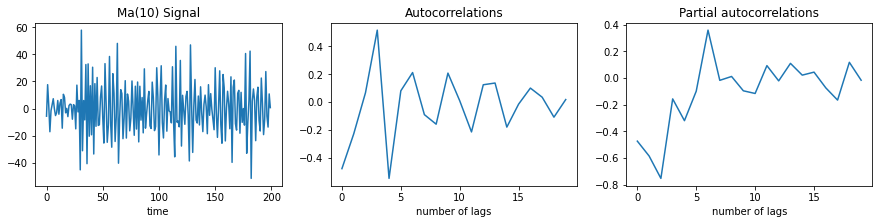

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.plot(y_obs[0])
plt.title("Ma(10) Signal")
plt.xlabel("time")
plt.subplot(132)
plt.title("Autocorrelations")
plt.xlabel("number of lags")
plt.plot(pautocorr(y_obs,Ncov)[0,0::4]);
plt.subplot(133)
plt.title("Partial autocorrelations")
plt.xlabel("number of lags")
plt.plot(pautocorr(y_obs,Ncov)[0,1::4])
plt.savefig("modelchoice-Signal.svg", format="svg")
#print('Thetas : ', modsimple[0])

## Setting the ABC pipeline

In [6]:
import elfi

We choose 11 models with $q$ ranging from 6 to 16.

In [7]:
qpriors = np.arange(6,17,dtype=np.int)
nclasses = qpriors.shape[0]
maxt = np.max(qpriors)

We penalize the model complexity in the class prior, choosing a linear decrease of probability of class sampling for increasing complexity, here it is just the $q$ class.

In [8]:
class ClassPrior(elfi.Distribution):
    def rvs(n, size=1, random_state=None):
        random_state = random_state or np.random
        return random_state.choice(n,size,p=np.arange(n,0,-1)/(n*(n+1)/2))

### Wrapping priors, custom classes

We have to sample the priors corresponding to each class $q$, with a sampled $\theta_q$ in $[1,2]$ this is the purpose of the `GlobalPrior` wrapper.

In [9]:
class GlobalPrior(elfi.Distribution):
    def rvs(qp, tq, qpriors, size=1, random_state=None):
        class_count = np.zeros(qpriors.shape[0], dtype='int')
        res = np.zeros((size[0], maxt))
        for q in range(qpriors.shape[0]):
            qr = qpriors[q]
            class_count[q] = np.sum(qp == q)
            if (class_count[q] > 0):
                res[qp == q, :qr] = generate_maq_priors(
                    qr, tq[qp == q], class_count[q],random_state)
        return res

Prior declarations and dependances

In [10]:
tq = elfi.Prior('uniform',1,1)
qp = elfi.Prior(ClassPrior, nclasses)
t  = elfi.Prior(GlobalPrior, qp, tq, qpriors)

Final stages, summary stats, simulator and distance

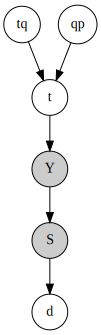

In [11]:
Y = elfi.Simulator(MAq, t, observed=y_obs)
S = elfi.Summary(pautocorr, Y, Ncov)
d = elfi.Distance('euclidean', S)
elfi.draw(d)

In [12]:
elfi.set_client('multiprocessing')
rej = elfi.Rejection(d,batch_size=batchsize,output_names=['S'])

### ABC samping

In [13]:
print('ABC sampling without rejection')
result_modelchoice = rej.sample(nref,quantile=1.0)

ABC sampling without rejection
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [14]:
print("Class sampled repartition : ")
print([np.sum(result_modelchoice.samples['qp'] == i)/nref for i in range(nclasses)])

Class sampled repartition : 
[0.17, 0.137, 0.145, 0.131, 0.1115, 0.0895, 0.062, 0.056, 0.049, 0.0305, 0.0185]


# AbcRanger, posterior Model Choice

In [15]:
import sys
sys.path.insert(0,'../build')
import pyabcranger

def listvar(prefix, s):
    return [prefix+str(i) for i in range(1, s+1)]

def listvarautocorr(s):
    arr = []
    for i in range(1, s//Ncovmult+1):
        arr.append("acf"+str(i))
        arr.append("pacf"+str(i))
        arr.append("pacfq1_"+str(i))
        arr.append("pacfq2_"+str(i))
    return arr

In [16]:
rf = pyabcranger.reftable(
    nref,
    np.histogram(result_modelchoice.samples['qp'],bins=nclasses)[0],
    qpriors,
    listvar('t',maxt),
    listvarautocorr(result_modelchoice.outputs['S'].shape[1]),
    result_modelchoice.outputs['S'],
    result_modelchoice.samples['t'],
    result_modelchoice.samples['qp']+1
)

In [17]:
postres = pyabcranger.modelchoice(rf, S.observed[0],"--ntree "+str(500),False)
print('Predicted model  : q =', qpriors[postres.predicted_model])
print('votes : ', postres.votes)
print('Posterior probability : ', postres.post_proba)

///////////////////////////////////////// First forest (training on ABC output)
Growing trees ..
  ████████████████████████████████████████▏ 100.0% [ 500/ 500 | 879.5 Hz | 1s<0s]  
Computing prediction error ..
///////////////////////////////////////// Second forest (training on error)
Growing trees ..
  ████████████████████████████████████████▏ 100.0% [ 500/ 500 | 4.7 kHz | 0s<0s]  
Computing prediction error ..
 votes model1 votes model2 votes model3 votes model4 votes model5 votes model6 votes model7 votes model8 votes model9 votes model10 votes model11 selected model post proba
           34           26           61           25          156           22           34           36           78           15           13              5      0.319
Predicted model  : q = 10
votes :  [34, 26, 61, 25, 156, 22, 34, 36, 78, 15, 13]
Posterior probability :  0.31860000000000005


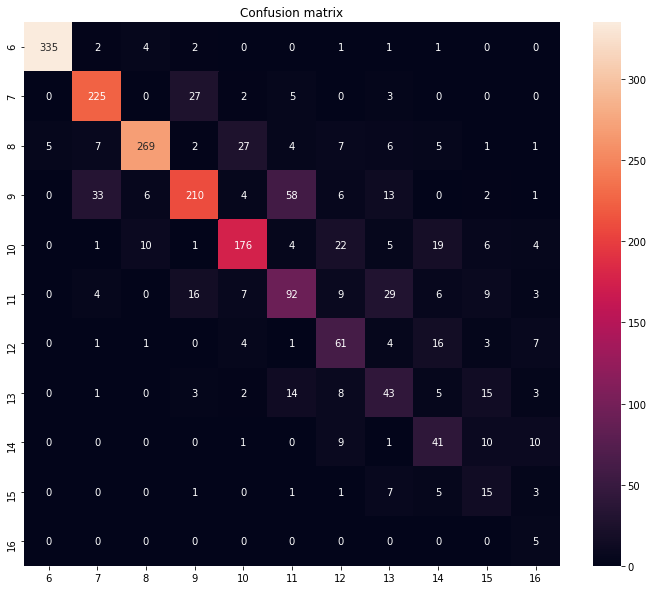

In [18]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(postres.confusion_matrix,qpriors,qpriors)
plt.figure(figsize=(12,10))
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt='d')
plt.title('Confusion matrix');

### Prior oob error (by number of tree)

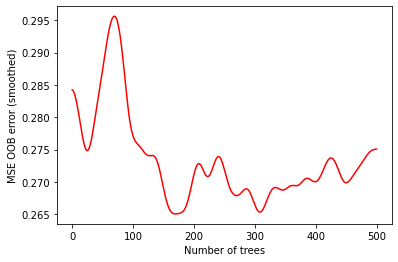

In [19]:
from scipy.ndimage.filters import gaussian_filter1d
ntree_oob_error_smoothed = gaussian_filter1d(postres.ntree_oob_error, sigma=10.0)
plt.figure()
#plt.scatter(range(ntree),postres.ntree_oob_error,color='b',marker='.')
plt.plot(ntree_oob_error_smoothed,'r')
#plt.yscale('log')
plt.xlabel('Number of trees')
plt.ylabel('MSE OOB error (smoothed)');

### Variable importance

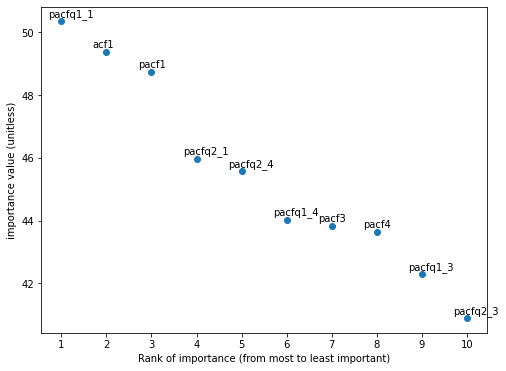

In [20]:
l  = len(postres.variable_importance)
ntop = min(10,l)
#lr = range(l-1,-1,-1)
lr = range(ntop)
labels = [postres.variable_importance[i][0] for i in lr]
imp    = [postres.variable_importance[i][1] for i in lr]
plt.figure(figsize=(8, 6))
plt.xticks(range(1,ntop+1))
for i in range(ntop):
    plt.text(i+0.7,imp[i]+0.15,labels[i])
plt.xlabel('Rank of importance (from most to least important)')
plt.ylabel('importance value (unitless)')
plt.scatter(range(1,ntop+1),imp)
plt.savefig("modelchoice-rank.svg",format="svg");

# Parameter estimation

We chose the $q=10$ model and now we want to get parameter estimation.
Let's sample only this model (with the same previously defined priors, of course). The only change to our previous pipeline is the `ClassPrior` $qp$, now fixed to $10$.

In [21]:
qp.become(elfi.Prior(ClassPrior, 1))
t.become(elfi.Prior(GlobalPrior, qp, tq, np.array([10])))

We also add a dependant prior $\theta_{m}$, as the mean of all $\theta$'s 

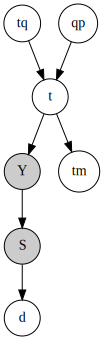

In [22]:
class DependantPrior(elfi.Distribution):
    def rvs(t, size=1, random_state=None):
        return np.mean(np.abs(t), axis=1)
    
tm = elfi.Prior(DependantPrior, t)
elfi.draw(d)

In [23]:
elfi.set_client('multiprocessing')
rej = elfi.Rejection(d,batch_size=batchsize,output_names=['S'])

In [24]:
print('ABC sampling without rejection')
result_estimparam = rej.sample(nref,quantile=1.0)

ABC sampling without rejection
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [25]:
params = np.concatenate([result_estimparam.samples['t'][:,:10],
                         result_estimparam.samples['tm'][:,np.newaxis]],axis=1)

rf = pyabcranger.reftable(
    nref,
    [0],
    [q],
    listvar('t',q) + ['tm'],
    listvarautocorr(result_estimparam.outputs['S'].shape[1]),
    result_estimparam.outputs['S'],
    params,
    np.ones(nref)
)

In [26]:
from tqdm.notebook import tqdm

def estimparam_args(i):
    if (i == q + 1):
        l = 'm'
    else: 
        l = str(i)
    return " ".join(['-n ',str(nref),'--ntree ' + str(ntree),'--parameter t' + l,'--noob 0','--chosenscen 1'])

# Parameter estimation for all parameters thetas
postres = [pyabcranger.estimparam(rf,S.observed[0],estimparam_args(i),True,False) for i in tqdm(range(1,q+2))]

## Simple scoring

In [27]:
reality = np.r_[modsimple[0],[np.mean(np.abs(modsimple[0]))]]

print('Scores : ')
print('NMAE abc + mean : ',np.mean(np.abs((reality-np.mean(params,axis=0))/reality)))
print('NMAE abc + rf   : ',np.mean(np.abs((reality-np.array([postres[i].point_estimates['Expectation'] 
                                                             for i in range(q+1)]))/reality)))

Scores : 
NMAE abc + mean :  9.16667443931472
NMAE abc + rf   :  1.9220749643393347


## Posterior distributions

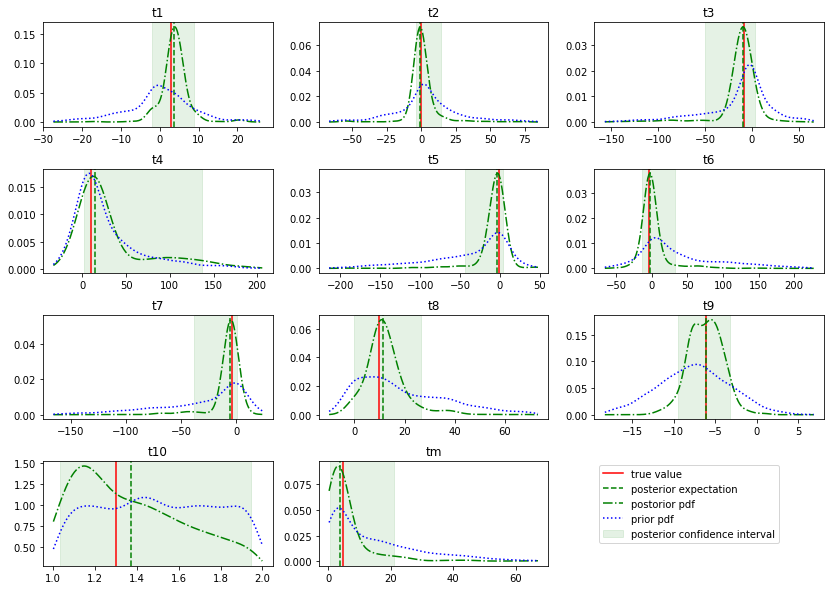

In [36]:
from scipy.stats import gaussian_kde
columns = 3
rows = ((q + 1) // columns) + 1
fig, axs = plt.subplots(rows,columns,figsize=(14, 10))
for i in range(columns * rows):
    ax = axs[i // columns, i % columns]
    if (i >= q + 1):
        ax.axis('off')
    else:
        x,y = np.asanyarray(postres[i].values_weights)[:,0],np.asanyarray(postres[i].values_weights)[:,1]
        pdfw = gaussian_kde(x,weights=y)
        pdf = gaussian_kde(x)
        xp = np.linspace(np.min(x),np.max(x),200)
        if (i == q):
            l = 'm'
        else: 
            l = str(i+1)
        ax.set_title('t' + l)
        ax.axvline(x=reality[i], color='r')
        ax.axvline(postres[i].point_estimates['Median'], color='g', linestyle = '--')
        ax.axvspan(postres[i].point_estimates['Quantile_0.05'],
                   postres[i].point_estimates['Quantile_0.95'],
                   alpha=0.1,color='g')
        ax.plot(xp,pdfw(xp),color="g",linestyle = '-.')
        ax.plot(xp,pdf(xp),color="b", linestyle = 'dotted')

fig.legend(['true value',
            'posterior expectation',
            'postorior pdf','prior pdf',
            'posterior confidence interval'],
           loc='lower right',bbox_to_anchor=(.85, 0.15, .01, .05))
fig.subplots_adjust(hspace=0.4)
plt.savefig("posterior-distrib.svg",format="svg")